In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import warnings
import random
import os
import cv2

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNetV2

In [3]:
# path = 'D:\study-hk2\ML\ML\classification_fish\data\data_fix\Fish_Dataset_Segment' 
path = "D:\\study\\machine_learning\\classification_fish\\data\data_fix\\Fish_Dataset_Segment" # đường dẫn đến thư mục chứa dữ liệu
classes = [i for i in os.listdir(path) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [4]:
data = [] # mảng chứa dữ liệu
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data.append([img, folder])

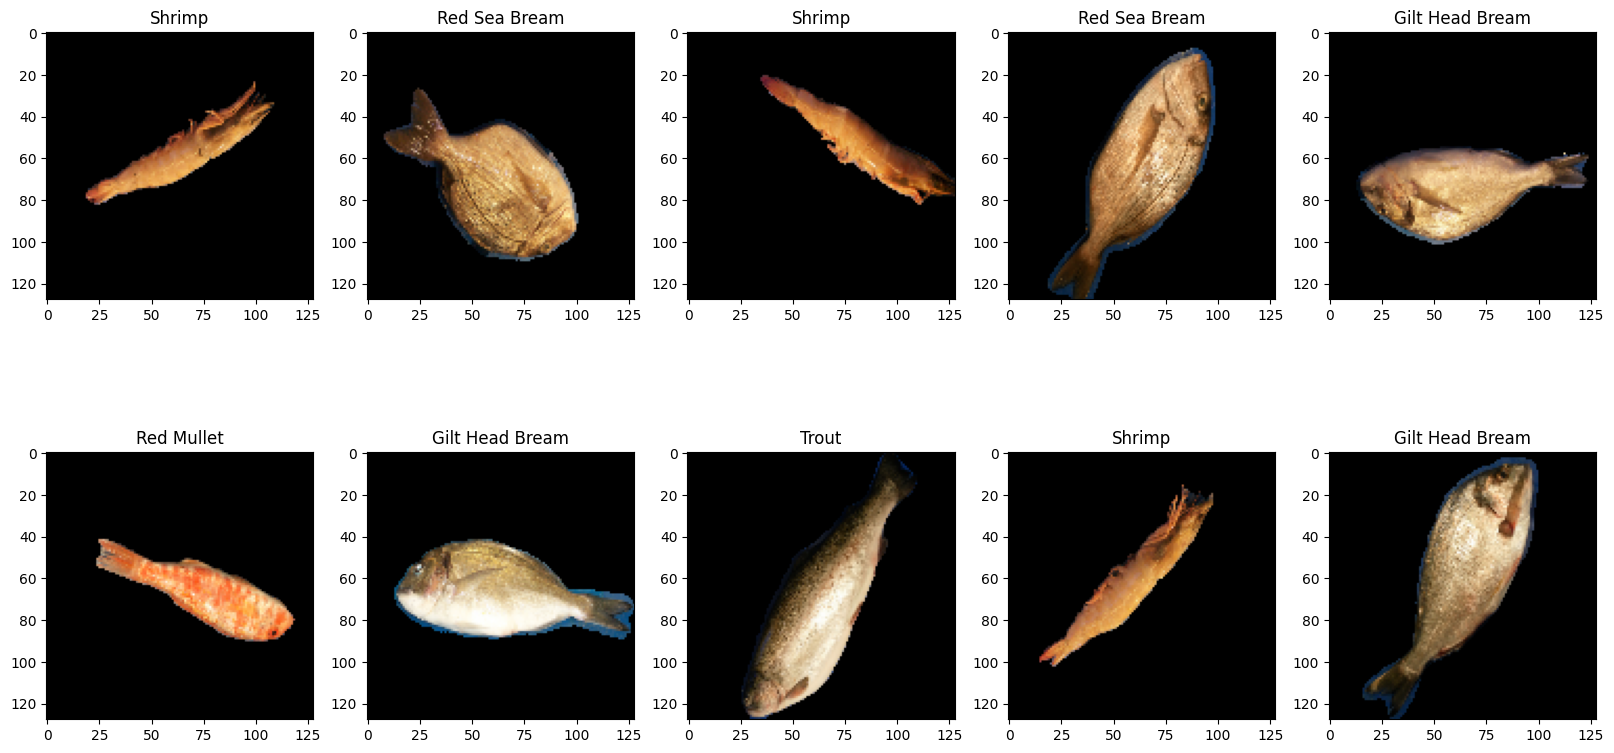

In [5]:
# hiện thị một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 8990)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [5]:
# shuffle dữ liệu
random.seed(42)
random.shuffle(data)

In [14]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [15]:
# chuấn hóa label thành dạng số
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [16]:
# chuyển images thành numpy array và chuẩn hóa về khoảng [0, 1]
images = np.array(images)
images = images.astype('float32') / 255.0
images.shape

(9000, 128, 128, 3)

In [17]:
pre_trained= MobileNetV2(include_top=False, pooling='avg', input_shape=(128, 128, 3))

In [18]:
# Lấy đặc trưng từ pre-trained model
features = pre_trained.predict(images)

282/282 [==============================] - 51s 179ms/step


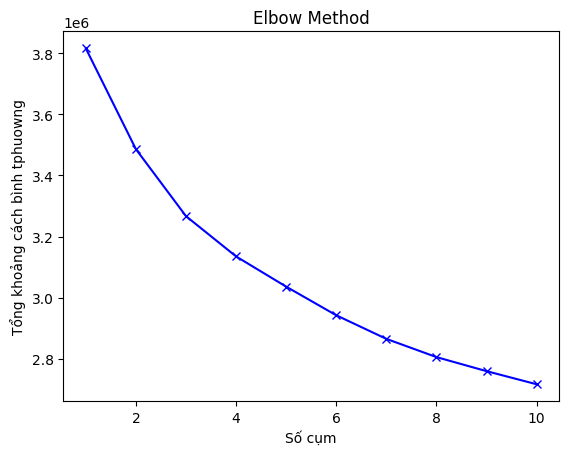

In [ ]:
warnings.filterwarnings("ignore")

# Khởi tạo một mảng lưu distortion cho mỗi số lượng cụm
distortions = []

# Thử các số lượng cụm từ 1 đến k_max
k_max = 10
for k in range(1, k_max+1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    distortions.append(kmeans.inertia_)

# Vẽ đồ thị elbow
plt.plot(range(1, k_max+1), distortions, 'bx-')
plt.xlabel('Số cụm')
plt.ylabel('Tổng khoảng cách bình tphuowng')
plt.title('Elbow Method')
plt.show()

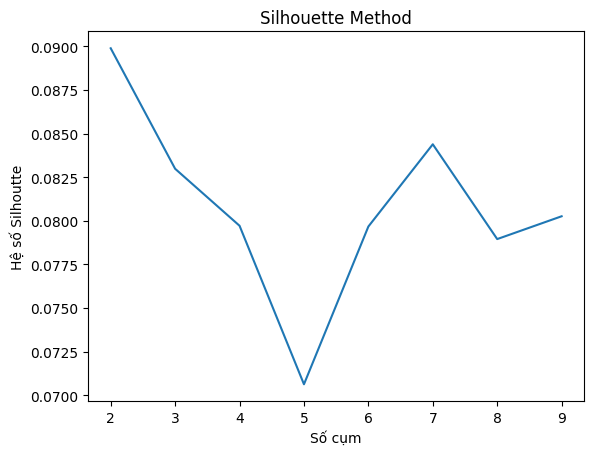

In [ ]:
warnings.filterwarnings("ignore")

scores = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(features)
    scores.append(silhouette_score(features, kmeans.labels_))

plt.plot(range(2, 10), scores)
plt.xlabel('Số cụm')
plt.ylabel('Hệ số Silhoutte')
plt.title('Silhouette Method')
plt.show()

In [35]:
# Áp dụng K-means để phân cụm
kmeans =  KMeans ( n_clusters = 9 , init = 'k-means++' , n_init = 1 , max_iter = 1000 , tol = 0.0001 , verbose = 0 , random_state = None , copy_x = True , algorithm = "lloyd" )
clusters = kmeans.fit_predict(features)

In [36]:
features.shape

(9000, 1280)

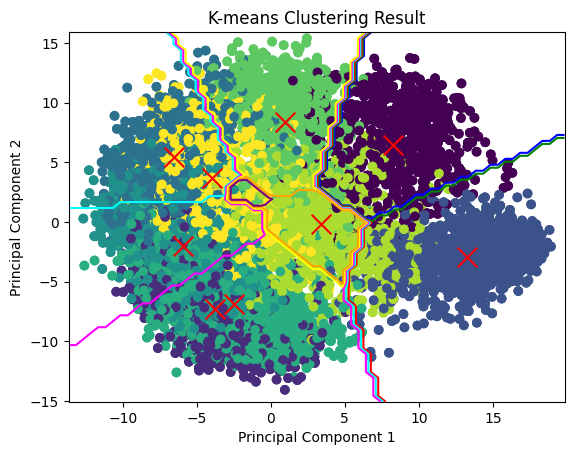

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Giảm chiều dữ liệu về 2 chiều bằng PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)

# Phân cụm và trực quan hóa kết quả
clusters = kmeans.labels_  # Lấy nhãn cụm từ K-means
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], marker='x', color='red', s=200)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering Result')

# Define the step size for the meshgrid
step = 0.5

# Generate a meshgrid of points with reduced step size
x_min, x_max = reduced_features[:, 0].min() - 1, reduced_features[:, 0].max() + 1
y_min, y_max = reduced_features[:, 1].min() - 1, reduced_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

# Convert the meshgrid points to float64 data type
mesh_points = np.c_[xx.ravel().astype('float64'), yy.ravel().astype('float64')]

# Convert the cluster centers to float32
reduced_cluster_centers = reduced_cluster_centers.astype('float32')

# Assign cluster labels to each point in the meshgrid
Z = kmeans.predict(pca.inverse_transform(mesh_points.astype('float32')))
Z = Z.reshape(xx.shape)

# Define a colormap with a color for each cluster
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'brown']

# Plot the scatter plot and cluster boundaries
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], marker='x', color='red', s=200)
for i in range(len(colors)):
    plt.contour(xx, yy, Z, levels=[i+0.5], colors=colors[i])

# Set the plot labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering Result')

# Show the plot
plt.show()

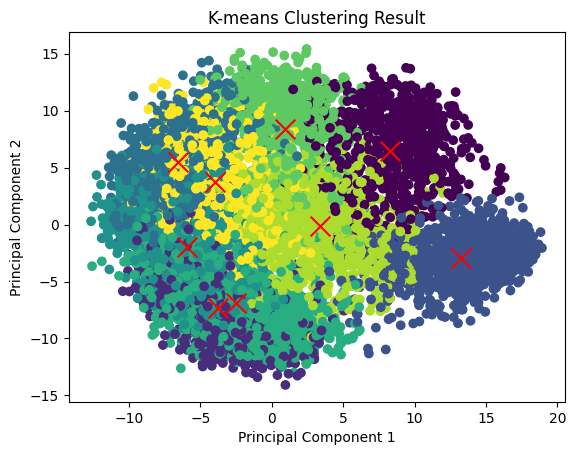

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Giảm chiều dữ liệu về 2 chiều bằng PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)

# Phân cụm và trực quan hóa kết quả
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], marker='x', color='red', s=200)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering Result')
plt.show()

In [14]:
new_labels = kmeans.labels_

In [15]:
unique_labels, counts = np.unique(new_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Cụm {label}: {count} điểm")

Cụm 0: 986 điểm
Cụm 1: 1316 điểm
Cụm 2: 698 điểm
Cụm 3: 822 điểm
Cụm 4: 924 điểm
Cụm 5: 1443 điểm
Cụm 6: 1096 điểm
Cụm 7: 834 điểm
Cụm 8: 881 điểm


In [48]:
# Áp dụng K-means để phân cụm
kmeans =  KMeans ( n_clusters = 9 , init = 'k-means++' , n_init = 1 , max_iter = 1000 , tol = 0.0001 , verbose = 0 , random_state = None , copy_x = True , algorithm = "lloyd" )
clusters = kmeans.fit_predict(features)

In [49]:
# xác định vị trí các ảnh là tâm của các cluster
center_id = []
for i in range(9):
    center_id.append(np.where(clusters == i)[0][0])
center_id

[4, 1, 7, 6, 9, 32, 8, 5, 0]

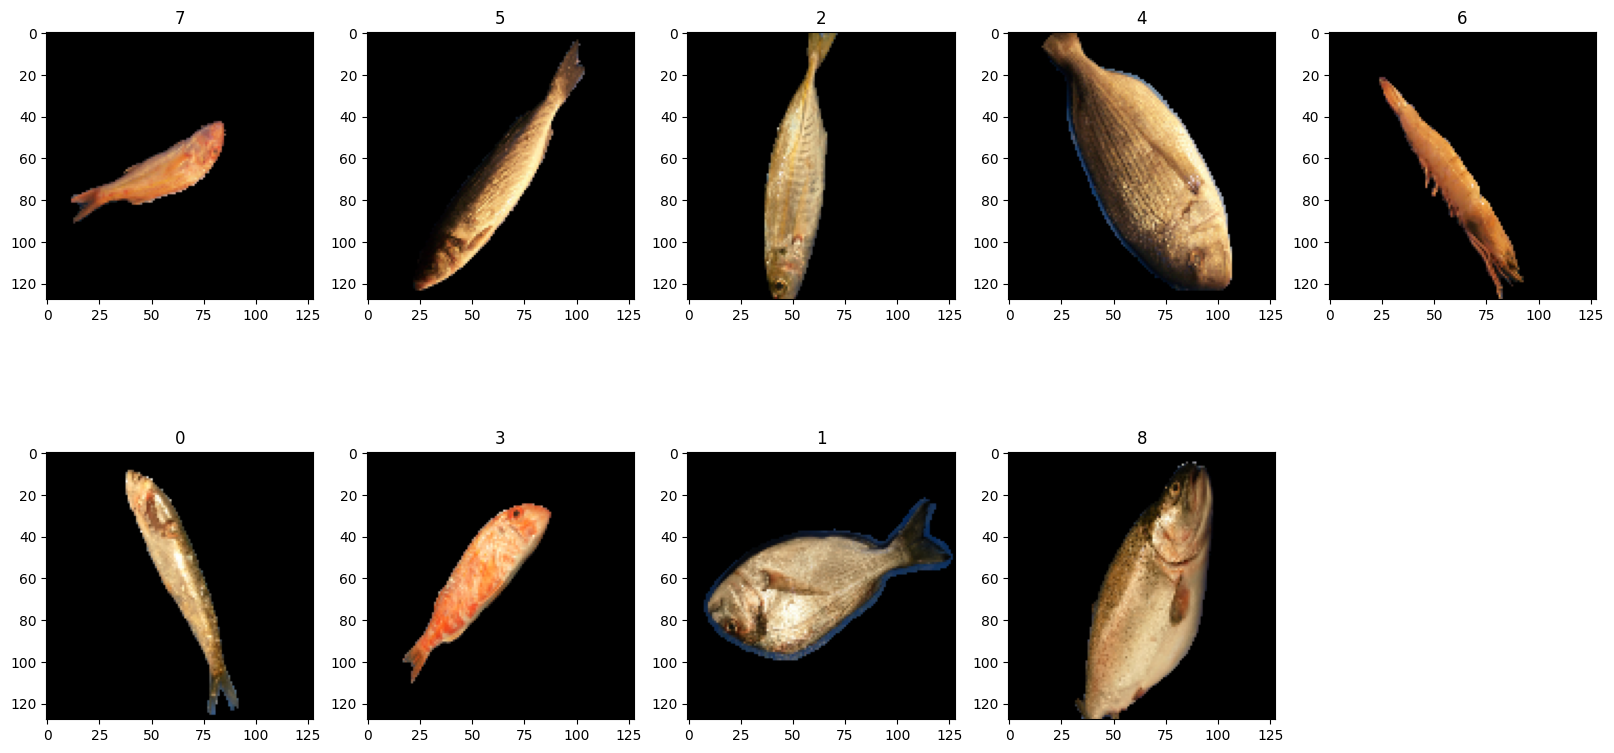

In [50]:
# in ra các ảnh là tâm của các cluster
plt.figure(figsize=(20, 10))
for i in range(9):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[center_id[i]].reshape(128, 128, 3))
    # plt.title(i)
    plt.title(labels[center_id[i]])

In [51]:
--

SyntaxError: invalid syntax (3659366440.py, line 1)

# In 20 ảnh gần tâm cụm nhất

C:\Users\vannt\AppData\Local\Temp\ipykernel_19184\2918867833.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, images_per_row, i+1)


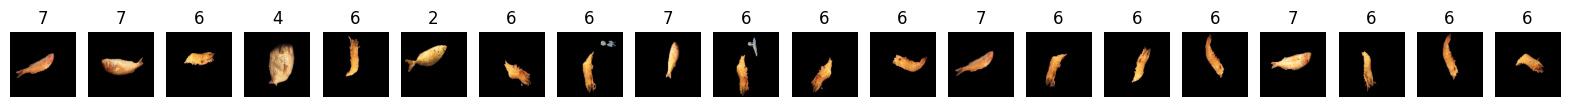

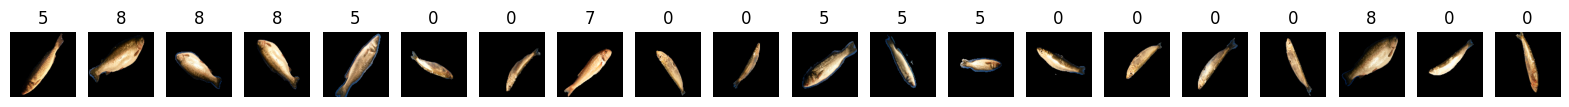

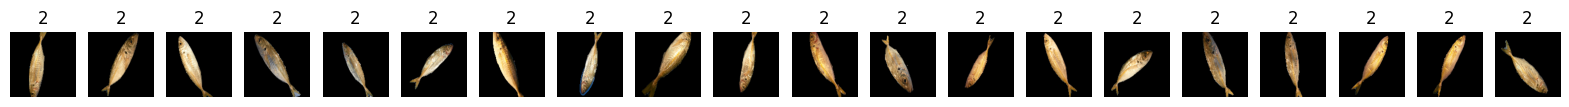

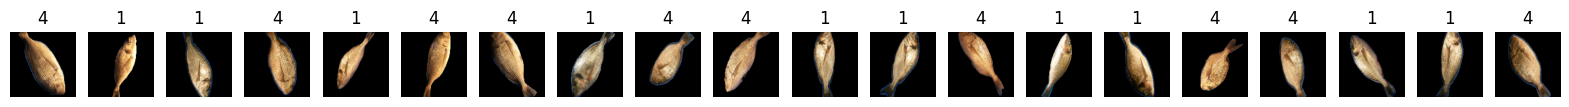

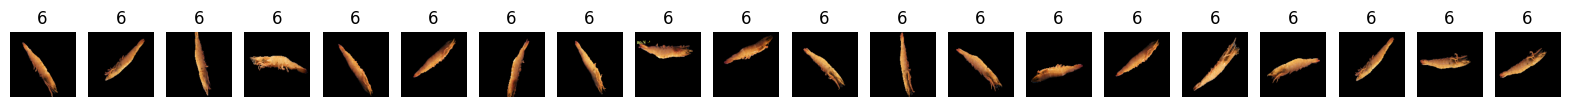

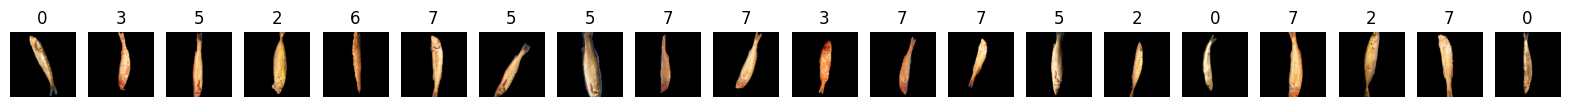

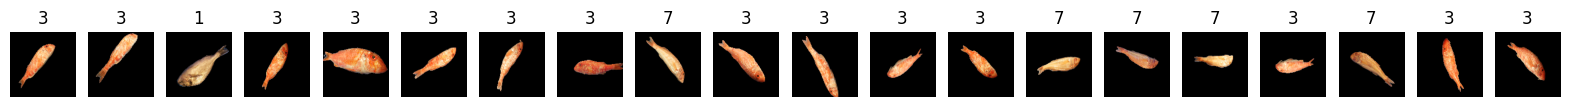

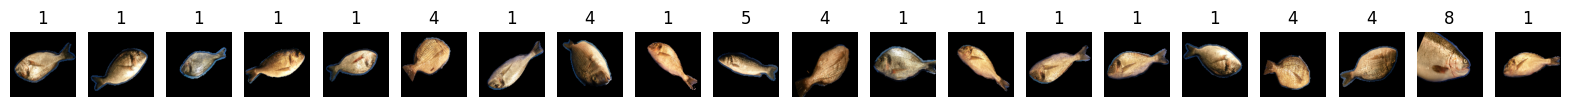

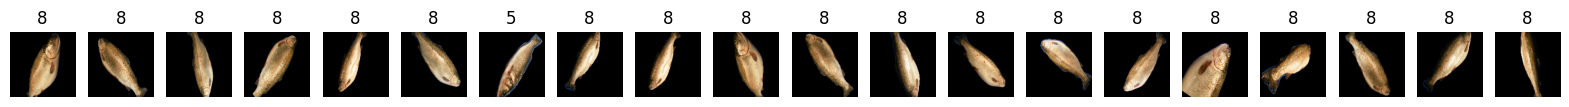

In [52]:
import matplotlib.pyplot as plt

# Tâm cụm
cluster_centers = np.array(kmeans.cluster_centers_)

num_clusters = cluster_centers.shape[0]
images_per_row = 20

for cluster_id in range(num_clusters):
    cluster_center = cluster_centers[cluster_id]

    # Trực  quan hình ảnh cụm và các ảnh trọng mỗi cụm
    plt.figure(figsize=(20, 1))

    # Trực quan ảnh là cụm
    plt.subplot(1, images_per_row + 1, 1)
    plt.imshow(images[cluster_id].reshape(128,128,3))
    plt.title(labels[cluster_id])
    plt.axis('off')

    # Lấy chỉ mục của các cụm
    cluster_indices = np.where(clusters == cluster_id)[0]

    #  Trực quan các ảnh trong cụm
    for i, img_idx in enumerate(cluster_indices[:images_per_row]):
        img = images[img_idx]
        plt.subplot(1, images_per_row, i+1)
        plt.imshow(img.reshape(128,128,3))
        plt.title(labels[img_idx])
        plt.axis('off')

    plt.show()

# Trực quan 20 ảnh xa cụm nhất

C:\Users\vannt\AppData\Local\Temp\ipykernel_19184\3530086663.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, images_per_row, i+1)


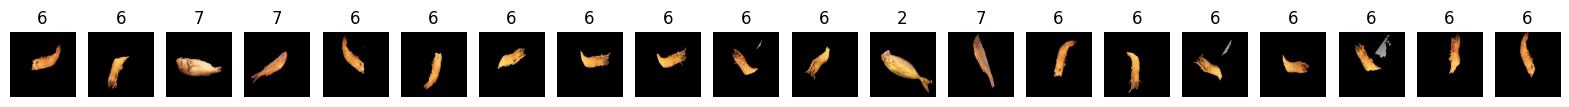

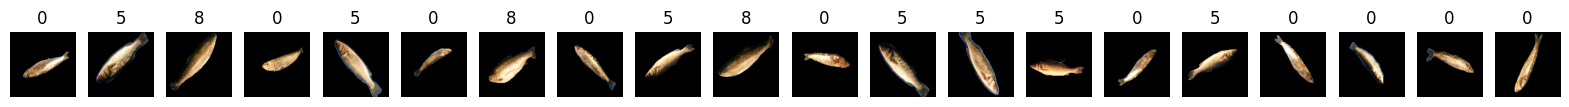

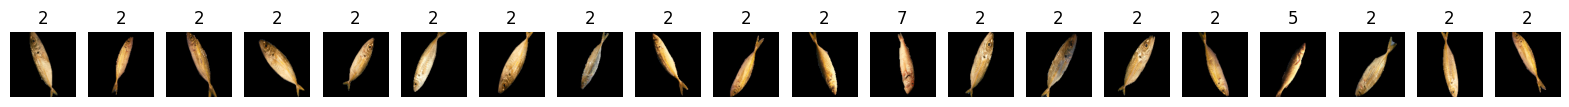

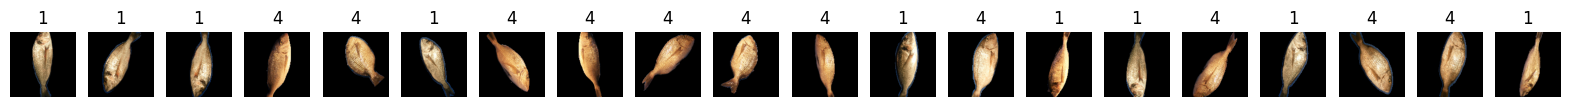

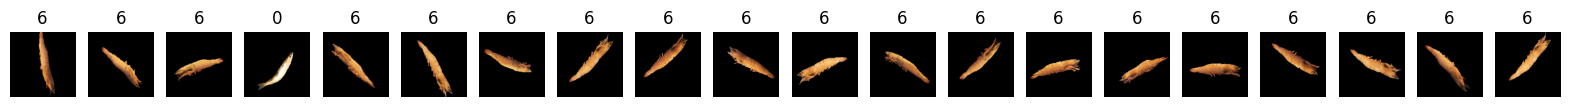

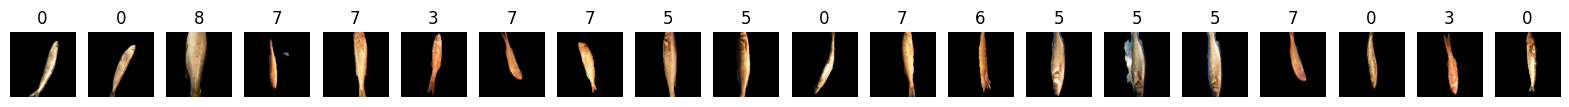

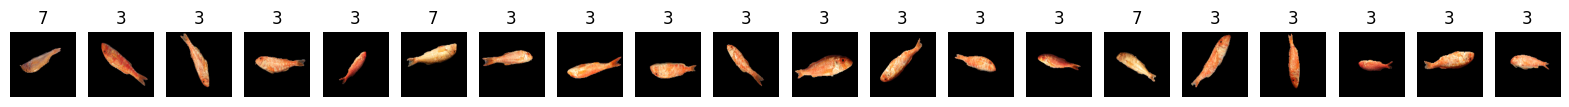

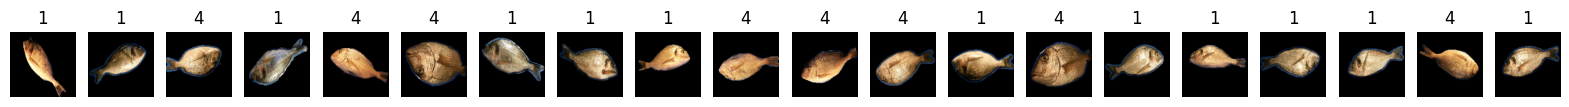

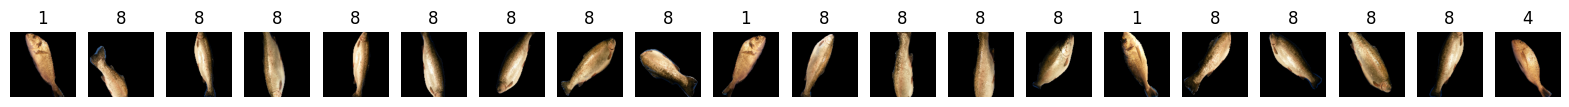

In [53]:
import matplotlib.pyplot as plt

# Tâm cụm 
cluster_centers = np.array(kmeans.cluster_centers_)

num_clusters = cluster_centers.shape[0]
images_per_row = 20

for cluster_id in range(num_clusters):
    cluster_center = cluster_centers[cluster_id]

    # Trực quan hình ảnh tâm cụm và các ảnh trong cụm
    plt.figure(figsize=(20, 1))

    # Trực quan hình ảnh là tâm cụm
    plt.subplot(1, images_per_row + 1, 1)
    plt.imshow(images[cluster_id].reshape(128,128,3))
    plt.title(labels[cluster_id])
    plt.axis('off')

    # Lấy chỉ mục của các tâm cụm
    cluster_indices = np.where(clusters == cluster_id)[0]

    # Trực quan các ảnh trong cụm
    for i, img_idx in enumerate(cluster_indices[-images_per_row:]):
        img = images[img_idx]
        plt.subplot(1, images_per_row, i+1)
        plt.imshow(img.reshape(128,128,3))
        plt.title(labels[img_idx])
        plt.axis('off')

    plt.show()

---

In [54]:
images = images.reshape(images.shape[0],-1)

# Trực quan kết quả phân cụm

In [55]:
num_clusters= 9
for cluster_id in range(num_clusters):
    cluster_center = cluster_centers[cluster_id]
    cluster_indices = np.where(clusters == cluster_id)[0]
    
    # Đếm số lượng mỗi nhãn trong cụm
    label_counts = np.bincount(labels[cluster_indices])
    
    print(f"Cụm {cluster_id} Nhãn tâm cụm: {labels[center_id][cluster_id]}")
  
    for label, count in enumerate(label_counts):
        print(f"Nhãn {label}: {count} mẫu")
    print("--------------------")


Cụm 0 Nhãn tâm cụm: 7
Nhãn 0: 3 mẫu
Nhãn 1: 0 mẫu
Nhãn 2: 9 mẫu
Nhãn 3: 0 mẫu
Nhãn 4: 4 mẫu
Nhãn 5: 0 mẫu
Nhãn 6: 260 mẫu
Nhãn 7: 35 mẫu
Nhãn 8: 2 mẫu
--------------------
Cụm 1 Nhãn tâm cụm: 5
Nhãn 0: 779 mẫu
Nhãn 1: 2 mẫu
Nhãn 2: 5 mẫu
Nhãn 3: 0 mẫu
Nhãn 4: 0 mẫu
Nhãn 5: 599 mẫu
Nhãn 6: 0 mẫu
Nhãn 7: 18 mẫu
Nhãn 8: 104 mẫu
--------------------
Cụm 2 Nhãn tâm cụm: 2
Nhãn 0: 7 mẫu
Nhãn 1: 12 mẫu
Nhãn 2: 909 mẫu
Nhãn 3: 3 mẫu
Nhãn 4: 7 mẫu
Nhãn 5: 7 mẫu
Nhãn 6: 0 mẫu
Nhãn 7: 29 mẫu
Nhãn 8: 2 mẫu
--------------------
Cụm 3 Nhãn tâm cụm: 4
Nhãn 0: 0 mẫu
Nhãn 1: 463 mẫu
Nhãn 2: 5 mẫu
Nhãn 3: 0 mẫu
Nhãn 4: 412 mẫu
Nhãn 5: 14 mẫu
Nhãn 6: 0 mẫu
Nhãn 7: 0 mẫu
Nhãn 8: 2 mẫu
--------------------
Cụm 4 Nhãn tâm cụm: 6
Nhãn 0: 17 mẫu
Nhãn 1: 2 mẫu
Nhãn 2: 3 mẫu
Nhãn 3: 0 mẫu
Nhãn 4: 0 mẫu
Nhãn 5: 4 mẫu
Nhãn 6: 571 mẫu
Nhãn 7: 3 mẫu
--------------------
Cụm 5 Nhãn tâm cụm: 0
Nhãn 0: 180 mẫu
Nhãn 1: 0 mẫu
Nhãn 2: 49 mẫu
Nhãn 3: 70 mẫu
Nhãn 4: 0 mẫu
Nhãn 5: 189 mẫu
Nhãn 6: 169 mẫu
Nhãn 7: 463 mẫu
Nhã

# Đếm số lượng trong mỗi cụm

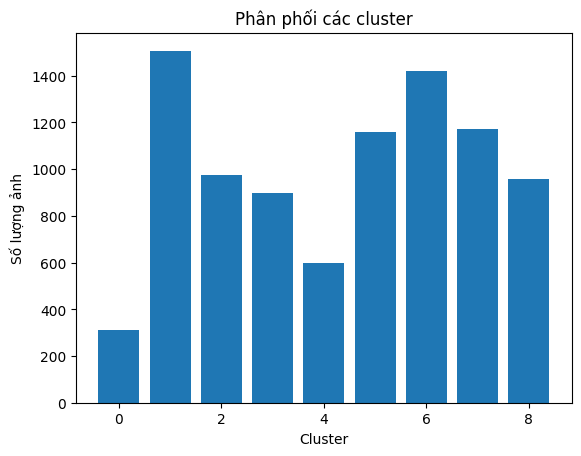

In [56]:
import matplotlib.pyplot as plt
hist, bins = np.histogram(clusters, bins=range(10))

# Vẽ histogram
plt.bar(bins[:-1], hist, align='center')
plt.xlabel('Cluster')
plt.ylabel('Số lượng ảnh')
plt.title('Phân phối các cluster')
plt.show()

# Trực quan các cụm trong toàn bộ dữ liệu -- 2D

C:\Users\vannt\AppData\Local\Temp\ipykernel_19184\3386533966.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(reduced_images[:, 0], reduced_images[:, 1], c=labels, cmap= plt.cm.get_cmap('jet', 10), alpha=0.7)


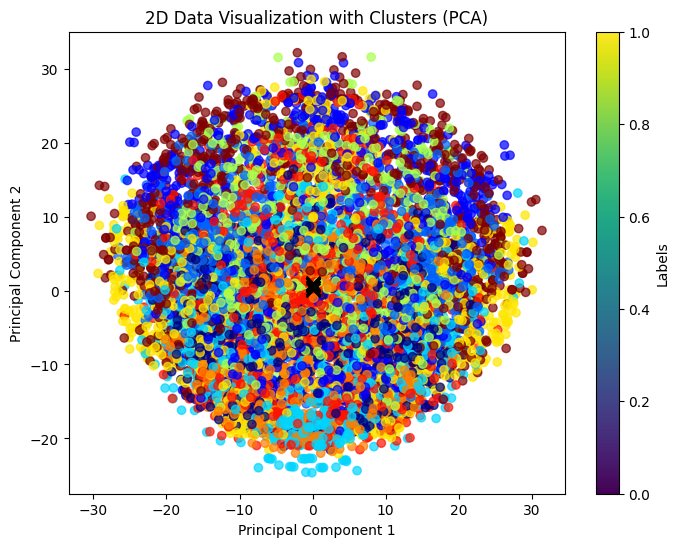

In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Giảm kích thước không gian dữ liệu xuống 2 chiều bằng PCA
pca = PCA(n_components=2)
reduced_images = pca.fit_transform(images)

# Trực quan hóa dữ liệu
plt.figure(figsize=(8, 6))
plt.scatter(reduced_images[:, 0], reduced_images[:, 1], c=labels, cmap= plt.cm.get_cmap('jet', 10), alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='x', s=100)
plt.title('2D Data Visualization with Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Labels')
plt.show()

# Trực quan các cụm trong toàn bộ dữ liệu -- 3D

In [58]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA


cluster_labels = ["Cluster 0", "Cluster 1", "Cluster 2","Cluster 3", "Cluster 4", "Cluster 5","Cluster 6", "Cluster 7", "Cluster 8" ]
# Giảm chiều dữ liệu xuống 3D bằng PCA
pca = PCA(n_components=3)
images_3d = pca.fit_transform(images)

# Tạo đối tượng Scatter3d để vẽ dữ liệu
scatter_data = go.Scatter3d(
    x=images_3d[:, 0],
    y=images_3d[:, 1],
    z=images_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=labels,  # Màu sắc dựa trên nhãn của dữ liệu
        colorscale='tempo',
        opacity=0.7,
        colorbar=dict(
            title='Labels'  # Tiêu đề của thanh màu
        )
    ),
    text=labels,
    hoverinfo='text'
)

# Xác định vị trí của các tâm cụm
pca1 = PCA(n_components=3)
centers_3d = pca1.fit_transform(kmeans.cluster_centers_)

# Tạo đối tượng Scatter3d để vẽ các tâm cụm
scatter_centers = go.Scatter3d(
    x=centers_3d[:, 0],
    y=centers_3d[:, 1],
    z=centers_3d[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color='red',  # Màu sắc đỏ cho tâm cụm
        symbol='x',
        line=dict(
            color='red',  # Màu sắc đỏ cho viền dấu x
            width=9
        )
    ),
    text=cluster_labels,
    hoverinfo='text'
)

# Tạo layout cho biểu đồ 3D
layout = go.Layout(
    title='PCA Visualization in 3D',
    scene=dict(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        zaxis=dict(title='Principal Component 3')
    ),
    width=1000,
    height=800
)

# Tạo đối tượng Figure và thêm Scatter3d vào đó
fig = go.Figure(data=[scatter_data, scatter_centers], layout=layout)

# Hiển thị biểu đồ 3D
fig.show()

In [59]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Giảm chiều dữ liệu xuống 3D bằng PCA
pca = PCA(n_components=3)
images_3d = pca.fit_transform(images)

# Tạo đối tượng Scatter3d để vẽ dữ liệu
scatter_data = go.Scatter3d(
    x=images_3d[:, 0],
    y=images_3d[:, 1],
    z=images_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=labels,  # Màu sắc dựa trên nhãn của dữ liệu
        colorscale='tempo',
        opacity=0.7,
        colorbar=dict(
            title='Labels'  # Tiêu đề của thanh màu
        )
    ),
    text=labels,
    hoverinfo='text'
)

# Xác định vị trí của các tâm cụm
pca1 = PCA(n_components=3)
centers_3d = pca1.fit_transform(kmeans.cluster_centers_)

# Tạo đối tượng Scatter3d để vẽ các tâm cụm
scatter_centers = go.Scatter3d(
    x=centers_3d[:, 0],
    y=centers_3d[:, 1],
    z=centers_3d[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color='red',  # Màu sắc đỏ cho tâm cụm
        symbol='x',
        line=dict(
            color='red',  # Màu sắc đỏ cho viền dấu x
            width=9
        )
    ),
    text=cluster_labels,
    hoverinfo='text'
)

# Tạo layout cho biểu đồ 3D
layout = go.Layout(
    title='PCA Visualization in 3D',
    scene=dict(
        xaxis=dict(title='Principal Component 1', range=[-20, 20]),
        yaxis=dict(title='Principal Component 2', range=[-20, 20]),
        zaxis=dict(title='Principal Component 3', range=[-8, 8])
    ),
    width=1000,
    height=800
)

# Tạo đối tượng Figure và thêm Scatter3d vào đó
fig = go.Figure(data=[scatter_data, scatter_centers], layout=layout)

# Hiển thị biểu đồ 3D
fig.show()